In [2]:
############ START BOILERPLATE ############
#### Interactivity -- BOKEH
from bokeh.io import output_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
############ END BOILERPLATE ############
output_notebook()

Loading BokehJS ...

In [3]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../source")
from Match_Analytics import Match
from Tracking_Dynamics import calc_player_norm_positions
from Tracking_Visualization import plot_sliding_window
from Tracking_Filters import possesion_filter, ball_position_filter, time_window
from Tracking_Statistics import bivariate_normal_distribution

In [4]:
m1 = Match(data_source = 'metrica-sports', match_id = 2)

Initializing match: 2

Reading team: home
Reading team: away
Filtering dead time...

Match preprocessed successfully.



In [5]:
possesion_away, defense_home = possesion_filter(m1, possesion_team='Away')

In [6]:
defense_home, possesion_away = ball_position_filter(m1,home_df =defense_home, 
                                                    away_df = possesion_away, left_bound= -10, right_bound = 10)

In [7]:
plot_sliding_window(m1)

In [8]:
df = bivariate_normal_distribution(time_window(possesion_away, start = 1, end = 1001), m1.away_players)
df

,player_number,player,x_mean,y_mean,normx_mean,normy_mean,cov_x_std,cov_y_std,cov_angle,x_std,y_std,cov_normx_std,cov_normy_std,cov_norm_angle,normx_std,normy_std
0,15,Away_15,-1.346424,-23.456354,-0.117958,-1.439430,12.815334,5.799491,0.310618,12.330134,6.770130,0.301346,0.134871,0.005068,0.301343,0.134878
1,16,Away_16,-11.005733,-9.806521,-0.741537,-0.574683,9.509331,8.432412,0.222593,9.459690,8.488063,0.184208,0.247718,0.539779,0.202925,0.232634
2,17,Away_17,-10.511464,7.891230,-0.708773,0.535992,9.856899,7.007877,-0.174335,9.783296,7.110268,0.155822,0.195589,0.688138,0.172966,0.180606
3,18,Away_18,0.828537,22.590384,0.032293,1.461380,12.692609,5.394229,-0.276878,12.297910,6.241908,0.373984,0.217173,-0.773054,0.307665,0.303924
4,19,Away_19,11.432709,-23.764476,0.728779,-1.467137,11.141300,6.068438,0.180796,11.013893,6.296719,0.220854,0.369632,-0.020391,0.220936,0.369583
5,20,Away_20,-0.501568,1.576485,-0.054625,0.151791,9.906679,10.669065,0.099738,9.914525,10.661774,0.203472,0.502295,0.208398,0.224562,0.493227
6,21,Away_21,3.115083,-5.589294,0.185274,-0.310233,8.873637,10.355755,-0.699892,9.516641,9.768144,0.166202,0.393038,0.105149,0.170354,0.391257
7,22,Away_22,12.834397,21.947623,0.819953,1.432653,10.855493,12.839937,-0.678196,11.676921,12.097736,0.311614,0.618520,0.022762,0.311851,0.618400
8,23,Away_23,17.497585,4.268689,1.129507,0.302194,10.469589,8.810226,0.161723,10.429901,8.857174,0.194352,0.444247,0.078052,0.196832,0.443154
9,24,Away_24,16.946194,-3.699366,1.099042,-0.192084,9.540304,11.477875,-0.019670,9.541130,11.477189,0.173300,0.550327,-0.096745,0.180495,0.548009


In [9]:
def mean_quadratic_distance(window=60*10, step=30, team = defense_home, players = m1.home_players, axis = "x"):
    lower_time = 0
    upper_time = window
    period_df = time_window(team, start = lower_time, end = upper_time)
    r = np.empty(0)
    t = np.empty(0)
    r_player = {}
    x = {}
    y = {}
    tactics = []
    previous = bivariate_normal_distribution(period_df, players).set_index("player")
    current_r=0
    last_index = 0
    for player in players:
        try:
            x[player]=previous.loc[player]['normx_mean']
            y[player]=previous.loc[player]['normy_mean']
        except:
            pass
        r_player[player] = np.empty(0)
    while period_df['Time [s]'].max() < team['Time [s]'].max():
        lower_time += step
        upper_time += step
        period_df = time_window(team, start = lower_time, end = upper_time)
        bivariate = bivariate_normal_distribution(period_df, players).set_index("player")
        dqm=0
        N=0
        for player in players:
            try:
                dq = (bivariate.loc[player][f'norm{axis}_mean'])
                dqm += dq
                r_player[player] = np.append(r_player[player], dq)
                N+=1
            except:
                r_player[player] = np.append(r_player[player], np.nan)
                pass
        try:
            r = np.append(r, dqm/N)
            t = np.append(t, lower_time+window/2)
            if dqm/N > current_r + 10*np.std(r[last_index:]):
                for player in players:
                    try:
                        x[player]=bivariate.loc[player]['normx_mean']
                        y[player]=bivariate.loc[player]['normy_mean']
                    except:
                        print("Error")
                        pass
                current_r = dqm/N
                last_index = len(r)
                print(last_index)
                tactics.append(lower_time+window/2)
        except:
            r = np.append(r, np.nan)
            t = np.append(t, np.nan)
            print("Error")
            pass
    return r, t, r_player


Error
1
224
Error
Error
Error
1
Error
Error
Error
2
Error
Error
Error
3
Error
Error
Error
4
Error
Error
Error
5
Error
Error
Error
6
Error
Error
Error
7
Error
Error
Error
8
Error
Error
Error
9
Error
Error
Error
10


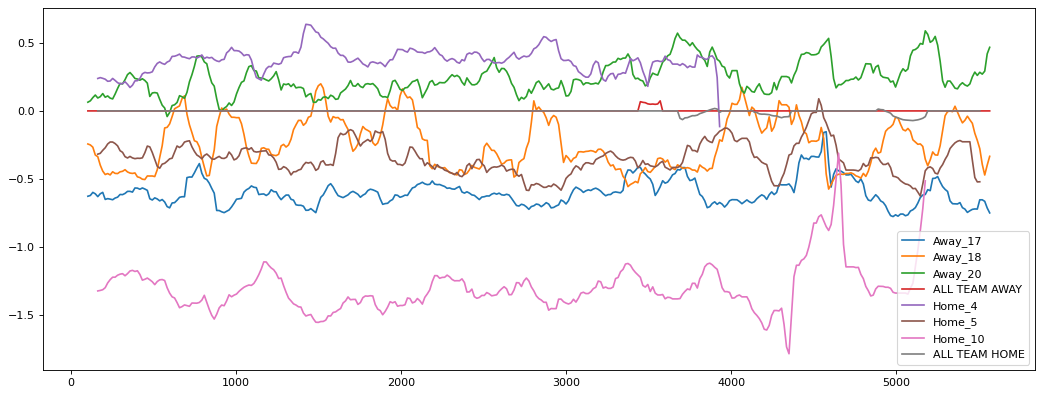

In [10]:
r,t,r_player = mean_quadratic_distance(60*3,15, m1.tracking_away, players=m1.away_players)
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in ["Away_17", "Away_18", "Away_20"]:
    try:
        plt.plot(t, r_player[player], label=f"{player}")
        pass
    except:
        pass   
plt.plot(t, r, label="ALL TEAM AWAY")
r,t,r_player = mean_quadratic_distance(60*5,15, team=m1.tracking_home, players=m1.home_players)
for player in ["Home_4", "Home_5", "Home_10"]:
    try:
        plt.plot(t, r_player[player], label=f"{player}")
        pass
    except:
        pass   
plt.plot(t, r, label="ALL TEAM HOME")
plt.legend()

224
225
Error
Error
Error
1
Error
Error
Error
2
Error
Error
Error
3
Error
Error
Error
4
Error
Error
Error
5
Error
Error
Error
6
Error
Error
Error
7
Error
Error
Error
8
Error
Error
Error
9
Error
Error
Error
10


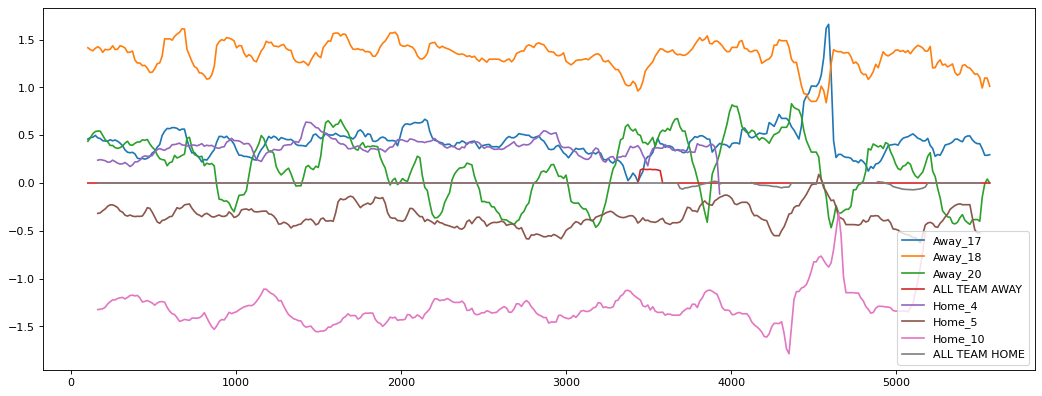

In [12]:
r,t,r_player = mean_quadratic_distance(60*3,15, m1.tracking_away, players=m1.away_players, axis = "y")
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in ["Away_17", "Away_18", "Away_20"]:
    try:
        plt.plot(t, r_player[player], label=f"{player}")
        pass
    except:
        pass   
plt.plot(t, r, label="ALL TEAM AWAY")
r,t,r_player = mean_quadratic_distance(60*5,15, team=m1.tracking_home, players=m1.home_players)
for player in ["Home_4", "Home_5", "Home_10"]:
    try:
        plt.plot(t, r_player[player], label=f"{player}")
        pass
    except:
        pass   
plt.plot(t, r, label="ALL TEAM HOME")
plt.legend()

In [13]:
indices = m1.events[m1.events["Type"] == "SET PIECE"].index[1:]
lower = m1.events.iloc[indices-1]['End Time [s]']
lower.index = indices
upper = m1.events.iloc[indices]['Start Time [s]']

ranges = pd.concat([lower,upper], axis=1)
filtered_home_df = m1.tracking_home
filtered_away_df = m1.tracking_away
for period in ranges.iterrows():
    filtered_home_df = filtered_home_df[~filtered_home_df['Time [s]'].between(period[1][0], period[1][1])]
    filtered_away_df = filtered_away_df[~filtered_away_df['Time [s]'].between(period[1][0], period[1][1])]

In [14]:
def rolling_window(tracking_data, players = None, window=5):
    temp_df = tracking_data[["Period", "Time [s]"]].copy()
    window = int(window/0.04)
    temp_df["mqd"] = 0
    
    for player in players:
        temp_df[f"{player}_x"] = tracking_data[f"{player}_x"].rolling(window).mean()
        temp_df[f"{player}_y"] = tracking_data[f"{player}_y"].rolling(window).mean()
        temp_df[f"{player}_normx"] = tracking_data[f"{player}_normx"].rolling(window).mean()
        temp_df[f"{player}_normy"] = tracking_data[f"{player}_normy"].rolling(window).mean()
        temp_df[f"{player}_vx"] = tracking_data[f"{player}_vx"].rolling(window).mean()
        temp_df[f"{player}_vy"] = tracking_data[f"{player}_vy"].rolling(window).mean()
        temp_df[f"{player}_std_x"] = tracking_data[f"{player}_x"].rolling(window).std()
        temp_df[f"{player}_std_y"] = tracking_data[f"{player}_y"].rolling(window).std()
        temp_df[f"{player}_std_normx"] = tracking_data[f"{player}_normx"].rolling(window).std()
        temp_df[f"{player}_std_normy"] = tracking_data[f"{player}_normy"].rolling(window).std()
        temp_df[f"{player}_std_vx"] = tracking_data[f"{player}_vx"].rolling(window).std()
        temp_df[f"{player}_std_vy"] = tracking_data[f"{player}_vy"].rolling(window).std()
        temp_df[f"{player}_max_vx"] = tracking_data[f"{player}_vx"].rolling(window).max()
        temp_df[f"{player}_min_vx"] = tracking_data[f"{player}_vx"].rolling(window).min()
        temp_df["mqd"] = temp_df["mqd"].add(
            ((tracking_data[f"{player}_normx"]-temp_df[f"{player}_normx"])**2+
            (tracking_data[f"{player}_normy"]-temp_df[f"{player}_normy"])**2)/11, fill_value=0)
    
    return temp_df

In [15]:
rolling = rolling_window(m1.tracking_home, m1.home_players, window = 60*1)

In [16]:
rolling_away = rolling_window(m1.tracking_away, m1.away_players, window = 60*1)

In [17]:
rolling.iloc[:1000]

,Period,Time [s],mqd,Home_1_x,Home_1_y,Home_1_normx,Home_1_normy,Home_1_vx,Home_1_vy,Home_1_std_x,...,Home_9_vx,Home_9_vy,Home_9_std_x,Home_9_std_y,Home_9_std_normx,Home_9_std_normy,Home_9_std_vx,Home_9_std_vy,Home_9_max_vx,Home_9_min_vx
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,1,45.40,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1136,1,45.44,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1137,1,45.48,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


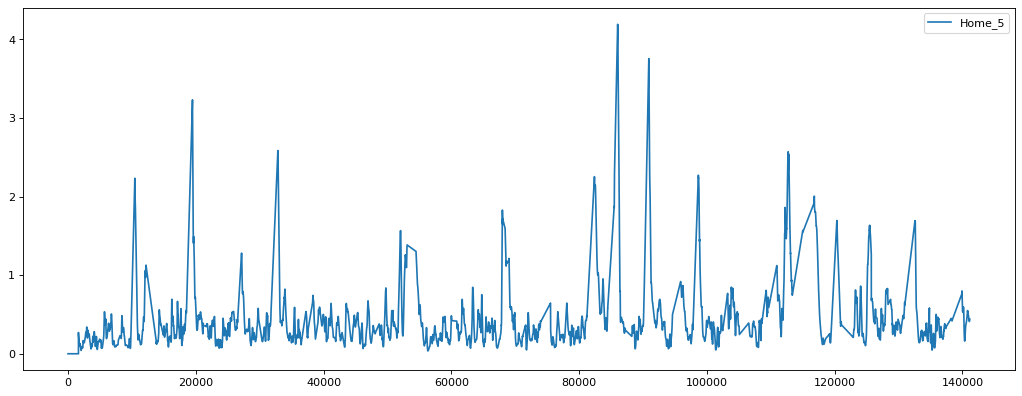

In [18]:
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in ["Home_5"]:
    plt.plot(rolling["mqd"], label=f"{player}")
    
plt.legend()

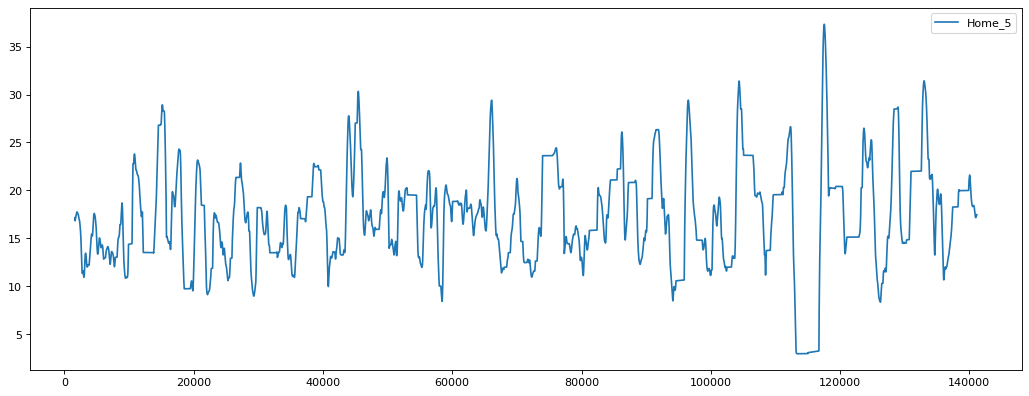

In [19]:
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in ["Home_5"]:
    plt.plot(np.sqrt(rolling[f"{player}_std_y"]**2+rolling[f"{player}_std_x"]**2), label=f"{player}")
    
plt.legend()

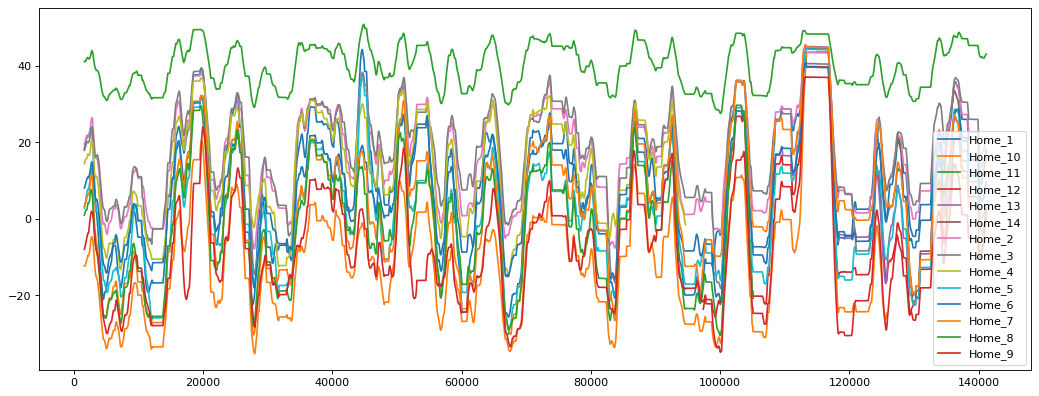

In [20]:
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in m1.home_players:
    plt.plot(rolling[f"{player}_x"], label=f"{player}")
    
plt.legend()

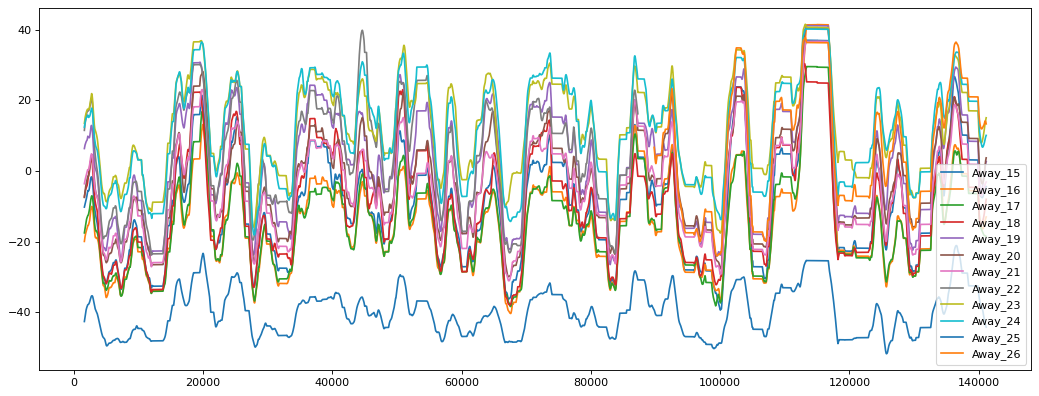

In [21]:
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in m1.away_players:
    plt.plot(rolling_away[f"{player}_x"], label=f"{player}")
    
plt.legend()

In [22]:
final_data=m1.events[(m1.events['Type']=='PASS') & (m1.events['Team']=='Away')].groupby(['From','To','Start Time [s]','End Time [s]','Start X','Start Y','End X','End Y']).size().reset_index(name="Freq")

In [23]:
final_data

,From,To,Start Time [s],End Time [s],Start X,Start Y,End X,End Y,Freq
0,Away_ 26,Away_15,4938.52,4939.24,50.88,-31.28,44.52,-33.32,1
1,Away_ 26,Away_15,5384.48,5386.12,14.84,-17.00,22.26,-30.60,1
2,Away_ 26,Away_16,4128.84,4131.44,30.74,-31.28,15.90,-29.92,1
3,Away_ 26,Away_18,4462.80,4463.96,27.56,1.36,21.20,16.32,1
4,Away_ 26,Away_24,5055.24,5056.92,-3.18,-24.48,10.60,-27.88,1
...,...,...,...,...,...,...,...,...,...
416,Away_25,Away_21,5600.40,5602.32,-39.22,-0.00,-14.84,20.40,1
417,Away_25,Away_22,2668.64,2670.04,-45.58,11.56,-14.84,24.48,1
418,Away_25,Away_23,198.24,201.64,-49.82,-0.00,2.12,14.28,1
419,Away_25,Away_23,4261.20,4264.44,-39.22,-4.08,18.02,14.28,1


In [24]:
size = final_data.groupby(['From','To']).sum().reset_index()
size

,From,To,Start Time [s],End Time [s],Start X,Start Y,End X,End Y,Freq
0,Away_ 26,Away_15,10323.00,10325.36,65.72,-48.28,66.78,-63.92,2
1,Away_ 26,Away_16,4128.84,4131.44,30.74,-31.28,15.90,-29.92,1
2,Away_ 26,Away_18,4462.80,4463.96,27.56,1.36,21.20,16.32,1
3,Away_ 26,Away_24,5055.24,5056.92,-3.18,-24.48,10.60,-27.88,1
4,Away_15,Away_ 26,13850.40,13853.68,36.04,-87.72,68.90,-85.68,3
...,...,...,...,...,...,...,...,...,...
89,Away_25,Away_20,2278.32,2279.20,-46.64,5.44,3.18,-3.40,1
90,Away_25,Away_21,5600.40,5602.32,-39.22,0.00,-14.84,20.40,1
91,Away_25,Away_22,2668.64,2670.04,-45.58,11.56,-14.84,24.48,1
92,Away_25,Away_23,4459.44,4466.08,-89.04,-4.08,20.14,28.56,2


In [25]:
vals = np.unique(size[['From', 'To']])
df2 = pd.DataFrame(0, index=vals, columns=vals)
f = df2.index.get_indexer
df2.values[f(size.From), f(size.To)] = size.Freq.values
df2

,Away_ 26,Away_15,Away_16,Away_17,Away_18,Away_19,Away_20,Away_21,Away_22,Away_23,Away_24,Away_25
Away_ 26,0,2,1,0,1,0,0,0,0,0,1,0
Away_15,3,0,22,0,0,10,7,10,0,3,4,0
Away_16,0,17,0,21,0,2,8,5,0,1,0,0
Away_17,0,6,11,0,16,1,4,6,1,1,0,1
Away_18,0,0,1,9,0,3,7,8,16,3,2,2
Away_19,0,10,2,1,2,0,4,3,0,3,2,0
Away_20,4,3,4,4,8,5,0,6,5,8,5,0
Away_21,0,11,2,8,9,6,8,0,2,2,5,0
Away_22,0,0,1,0,8,3,2,1,0,2,2,0
Away_23,1,3,0,0,1,3,2,1,4,0,6,0


In [33]:
from scipy.sparse import csr_matrix

df_ohe = csr_matrix(df2.values)
df_ohe

<12x12 sparse matrix of type '<class 'numpy.int64'>'
	with 94 stored elements in Compressed Sparse Row format>

In [219]:
from Tracking_Statistics import bivariate_normal_distribution
from Tracking_Filters import time_window

In [221]:
home_df = bivariate_normal_distribution(m1.tracking_away, m1.away_players)

home_df

,player_number,player,x_mean,y_mean,normx_mean,normy_mean,cov_x_std,cov_y_std,cov_angle,x_std,y_std,cov_normx_std,cov_normy_std,cov_norm_angle,normx_std,normy_std
0,15,Away_15,-9.736417,-18.351560,-0.271904,-1.402074,20.538517,8.827615,0.152896,20.343392,9.268435,0.355717,0.418022,0.064125,0.355996,0.417786
1,16,Away_16,-15.341636,-8.112190,-0.615634,-0.602573,18.022022,8.473108,0.042141,18.009560,8.499564,0.270576,0.331280,0.709546,0.297856,0.306985
2,17,Away_17,-15.306021,5.274190,-0.612827,0.428753,17.452664,7.688797,-0.026595,17.447690,7.700077,0.251303,0.348208,-0.192893,0.255516,0.345129
3,18,Away_18,-8.915240,16.902923,-0.231719,1.337904,20.795458,8.399662,-0.095873,20.715570,8.594797,0.442052,0.341619,-0.552088,0.416846,0.371958
4,19,Away_19,2.433028,-8.593085,0.523230,-0.643012,21.348189,17.609935,0.040633,21.342560,17.616757,0.358325,1.216948,-0.051592,0.363309,1.215469
5,20,Away_20,-2.646403,1.581150,0.230590,0.158027,19.380084,10.684713,-0.009134,19.379521,10.685734,0.321302,0.568363,0.088889,0.323986,0.566837
6,21,Away_21,-4.774768,-0.853912,0.084176,-0.044273,18.270902,11.084527,0.004035,18.270808,11.084682,0.219550,0.543610,-0.004881,0.219564,0.543604
7,22,Away_22,4.286456,17.078034,0.724663,1.389949,20.051490,9.896174,-0.065175,20.019296,9.961140,0.374544,0.563585,-0.174468,0.381611,0.558824
8,23,Away_23,12.058283,2.656038,1.221501,0.249702,18.148272,11.797259,0.026279,18.144654,11.802823,0.430660,0.778273,0.034631,0.431245,0.777949
9,24,Away_24,11.554648,-2.553937,1.186583,-0.195530,18.827514,12.348678,-0.054206,18.811762,12.372662,0.380124,0.806348,-0.001728,0.380126,0.806347


In [254]:
grouped = final_data.groupby(['From','To'])[['Start X','Start Y', 'End X', 'End Y']].mean().reset_index()
grouped['Pass X Mean'] = (grouped['Start X'] + grouped['End X'])/2
grouped['Pass Y Mean'] = (grouped['Start Y'] + grouped['End Y'])/2
grouped['X Mean'] = home_df['x_mean']
grouped['Y Mean'] = home_df['y_mean']
grouped

,From,To,Start X,Start Y,End X,End Y,Pass X Mean,Pass Y Mean,X Mean,Y Mean
0,Away_ 26,Away_15,32.860000,-24.14,33.390000,-31.96,33.125,-28.05,-9.736417,-18.351560
1,Away_ 26,Away_16,30.740000,-31.28,15.900000,-29.92,23.320,-30.60,-15.341636,-8.112190
2,Away_ 26,Away_18,27.560000,1.36,21.200000,16.32,24.380,8.84,-15.306021,5.274190
3,Away_ 26,Away_24,-3.180000,-24.48,10.600000,-27.88,3.710,-26.18,-8.915240,16.902923
4,Away_15,Away_ 26,12.013333,-29.24,22.966667,-28.56,17.490,-28.90,2.433028,-8.593085
...,...,...,...,...,...,...,...,...,...,...
89,Away_25,Away_20,-46.640000,5.44,3.180000,-3.40,-21.730,1.02,NaN,NaN
90,Away_25,Away_21,-39.220000,0.00,-14.840000,20.40,-27.030,10.20,NaN,NaN
91,Away_25,Away_22,-45.580000,11.56,-14.840000,24.48,-30.210,18.02,NaN,NaN
92,Away_25,Away_23,-44.520000,-2.04,10.070000,14.28,-17.225,6.12,NaN,NaN


In [255]:
plot = figure()

G = nx.DiGraph()

for index, row in grouped.iterrows():
    G.add_node(row['From'],pos=row[['Pass X Mean','Pass Y Mean']])

for index, row in size.iterrows():
    G.add_edge(row['From'], row['To'],weight=row['Freq'])

fixed_pos=grouped.set_index('To').T.to_dict('list')
fixed_nodes = fixed_pos.keys()
pos=nx.get_node_attributes(G,'pos')
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

graph = from_networkx(G,nx.spring_layout)
fixed_layout_provider = StaticLayoutProvider(graph_layout=pos)
graph.layout_provider = fixed_layout_provider

In [256]:
fixed_pos=grouped.set_index('To').T.to_dict('list')
fixed_nodes = fixed_pos.keys()
pos=nx.get_node_attributes(G,'pos')
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

In [257]:
edges

OutEdgeView([('Away_ 26', 'Away_15'), ('Away_ 26', 'Away_16'), ('Away_ 26', 'Away_18'), ('Away_ 26', 'Away_24'), ('Away_15', 'Away_ 26'), ('Away_15', 'Away_16'), ('Away_15', 'Away_19'), ('Away_15', 'Away_20'), ('Away_15', 'Away_21'), ('Away_15', 'Away_23'), ('Away_15', 'Away_24'), ('Away_16', 'Away_15'), ('Away_16', 'Away_17'), ('Away_16', 'Away_19'), ('Away_16', 'Away_20'), ('Away_16', 'Away_21'), ('Away_16', 'Away_23'), ('Away_17', 'Away_15'), ('Away_17', 'Away_16'), ('Away_17', 'Away_18'), ('Away_17', 'Away_19'), ('Away_17', 'Away_20'), ('Away_17', 'Away_21'), ('Away_17', 'Away_22'), ('Away_17', 'Away_23'), ('Away_17', 'Away_25'), ('Away_18', 'Away_16'), ('Away_18', 'Away_17'), ('Away_18', 'Away_19'), ('Away_18', 'Away_20'), ('Away_18', 'Away_21'), ('Away_18', 'Away_22'), ('Away_18', 'Away_23'), ('Away_18', 'Away_24'), ('Away_18', 'Away_25'), ('Away_19', 'Away_15'), ('Away_19', 'Away_16'), ('Away_19', 'Away_17'), ('Away_19', 'Away_18'), ('Away_19', 'Away_20'), ('Away_19', 'Away_21')

In [258]:
graph = from_networkx(G,nx.spring_layout)
fixed_layout_provider = StaticLayoutProvider(graph_layout=pos)
graph.layout_provider = fixed_layout_provider

graph.node_renderer.glyph = Circle(size=10,fill_color='blue', fill_alpha=1, line_alpha=1)
plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None
plot.axis.visible=False
graph.edge_renderer.data_source.data["line_width"] = [G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
graph.edge_renderer.glyph.line_width = {'field': 'line_width'}
graph.edge_renderer.glyph.line_alpha = {'field': 'line_width'}

plot.renderers.append(graph)

show(plot)

In [259]:
graph.layout_provider = StaticLayoutProvider(graph_layout=home_df[['normx_mean','normy_mean', 'player']].set_index('player').T.to_dict('list'))
show(plot)
home_df

,player_number,player,x_mean,y_mean,normx_mean,normy_mean,cov_x_std,cov_y_std,cov_angle,x_std,y_std,cov_normx_std,cov_normy_std,cov_norm_angle,normx_std,normy_std
0,15,Away_15,-9.736417,-18.351560,-0.271904,-1.402074,20.538517,8.827615,0.152896,20.343392,9.268435,0.355717,0.418022,0.064125,0.355996,0.417786
1,16,Away_16,-15.341636,-8.112190,-0.615634,-0.602573,18.022022,8.473108,0.042141,18.009560,8.499564,0.270576,0.331280,0.709546,0.297856,0.306985
2,17,Away_17,-15.306021,5.274190,-0.612827,0.428753,17.452664,7.688797,-0.026595,17.447690,7.700077,0.251303,0.348208,-0.192893,0.255516,0.345129
3,18,Away_18,-8.915240,16.902923,-0.231719,1.337904,20.795458,8.399662,-0.095873,20.715570,8.594797,0.442052,0.341619,-0.552088,0.416846,0.371958
4,19,Away_19,2.433028,-8.593085,0.523230,-0.643012,21.348189,17.609935,0.040633,21.342560,17.616757,0.358325,1.216948,-0.051592,0.363309,1.215469
5,20,Away_20,-2.646403,1.581150,0.230590,0.158027,19.380084,10.684713,-0.009134,19.379521,10.685734,0.321302,0.568363,0.088889,0.323986,0.566837
6,21,Away_21,-4.774768,-0.853912,0.084176,-0.044273,18.270902,11.084527,0.004035,18.270808,11.084682,0.219550,0.543610,-0.004881,0.219564,0.543604
7,22,Away_22,4.286456,17.078034,0.724663,1.389949,20.051490,9.896174,-0.065175,20.019296,9.961140,0.374544,0.563585,-0.174468,0.381611,0.558824
8,23,Away_23,12.058283,2.656038,1.221501,0.249702,18.148272,11.797259,0.026279,18.144654,11.802823,0.430660,0.778273,0.034631,0.431245,0.777949
9,24,Away_24,11.554648,-2.553937,1.186583,-0.195530,18.827514,12.348678,-0.054206,18.811762,12.372662,0.380124,0.806348,-0.001728,0.380126,0.806347


In [214]:
plot_sliding_window(m1)

In [61]:
import pandas as pd
import numpy as np
from bokeh.models.widgets import RangeSlider,Div
from bokeh.io import curdoc
from bokeh.layouts import column,layout
import networkx as nx
from bokeh.plotting import from_networkx
from bokeh.models import StaticLayoutProvider,Circle,LabelSet,ColumnDataSource,CustomJS
from bokeh.plotting import figure
from Tracking_Visualization import draw_pitch
from bokeh.io import show

In [25]:
range_slider = RangeSlider(start=0, end=5867, value=(0,2700), step=1, title="Game Seconds", width=800)

def player_plot():
    plot = draw_pitch()

    lower = np.round(range_slider.value[0])
    higher = np.round(range_slider.value[1])

    filter_data = final_data[(final_data['Start Time [s]']>=lower )& (final_data['End Time [s]']<=higher)]
    size = filter_data.groupby(['From','To']).size().reset_index(name="Freq")
    grouped = filter_data.groupby(['To'])[['Start X','Start Y']].mean().reset_index()

    G = nx.DiGraph()

    for index, row in grouped.iterrows():
        G.add_node(row['To'],pos=row[['Start X','Start Y']])

    for index, row in size.iterrows():
        G.add_edge(row['From'], row['To'],weight=row['Freq'])

    fixed_pos=grouped.set_index('To').T.to_dict('list')
    fixed_nodes = fixed_pos.keys()
    pos=nx.get_node_attributes(G,'pos')
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]

    graph = from_networkx(G,nx.spring_layout)
    fixed_layout_provider = StaticLayoutProvider(graph_layout=pos)
    graph.layout_provider = fixed_layout_provider

    graph.node_renderer.glyph = Circle(size=20,fill_color='orangered')
    plot.xgrid.grid_line_color = None
    plot.ygrid.grid_line_color = None
    plot.axis.visible=False
    graph.edge_renderer.data_source.data["line_width"] = [G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
    graph.edge_renderer.glyph.line_width = {'field': 'line_width'}

    plot.renderers.append(graph)
    pos_values=np.array(fixed_pos.values())

    coordinates=pd.DataFrame(pos_values,columns=['x','y'])
    coordinates['player'] =fixed_pos.keys()
    source = ColumnDataSource(data=dict(x=coordinates.x,y=coordinates.y,player=coordinates.player))
    labels = LabelSet(x='x', y='y', text='player', source=source,x_offset=-45, y_offset=-25,text_color='black',render_mode='canvas',text_font_size='10pt')
    plot.renderers.append(labels)
    return plot

def on_change(attr, old, new):
    layout.children[1] = player_plot()

for w in [range_slider]:
    w.on_change('value', on_change)
    
source_slider = ColumnDataSource(data=dict(value=[]))
source_slider.on_change('data', on_change)

range_slider.callback = CustomJS(args=dict(source=source_slider), code='source.data = { value: [cb_obj.value] }')

div = Div(text="""<b><h>DYNAMIC PASS NETWORK MAP</b></h></br></br>Dynamic network graph of passes between players in a football (soccer) 
match. The tool uses <a href="https://networkx.github.io/">NetworkX</a> and <a href="https://bokeh.pydata.org/en/latest/">Bokeh (Python)</a> 
to plot the graph.<br></br><a href="https://samirak93.github.io/analytics/projects/proj-2.html">Blog Post</a><br></br>
Adjust the slider to filter the passes between any 2 game seconds. Thickness of line indicates the volume of passes between 2 players
<br>Created by <b><a href="https://twitter.com/Samirak93">Samira Kumar</a></b> </br> Best viewed on Google Chrome""",
width=550, height=170)


layout=column(div,player_plot(),range_slider)

curdoc().add_root(layout)
curdoc().add_root(source_slider)
curdoc().title = "Dynamic Network Pass Map"

AttributeError: unexpected attribute 'callback' to RangeSlider, similar attributes are js_event_callbacks

In [26]:
import pandas as pd

In [27]:
team_name = "Away"
possesion = False
number_of_possesions = 0
possesions = {}

for index, row in m1.events.iterrows():
    if row['Team'] == team_name:
        if not possesion:
            number_of_possesions += 1
            possesions[number_of_possesions] = [row['Start Time [s]']]
            possesion = True
    else:
        if possesion:
            possesions[number_of_possesions].append(row['Start Time [s]'])
            possesion = False

In [28]:
filtered_possesion = pd.DataFrame()
filtered_defense = m1.tracking_home
for value in possesions.values():
    try:
        filtered_possesion = filtered_possesion.append(m1.tracking_away[m1.tracking_away['Time [s]'].between(value[0],value[1], inclusive = 'both')])
        filtered_defense = filtered_defense[~filtered_defense['Time [s]'].between(value[0],value[1], inclusive = 'both')]
    except IndexError:
        pass

In [29]:
not None

True

In [30]:
filtered_possesion

,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,...,Home_6_normx,Home_6_normy,Home_7_normx,Home_7_normy,Home_8_normx,Home_8_normy,Home_9_normx,Home_9_normy,ball_normx,ball_normy
Frame,,,,,,,,,,,,,,,,,,,,,
51,1,2.04,-52.66610,-0.19924,-12.16032,-21.80148,-20.29900,-4.48800,-19.65982,5.32576,...,1.614928,0.040217,1.462642,-0.334042,1.097067,-1.321872,0.866971,0.564127,0.872477,-0.091946
52,1,2.08,-52.66610,-0.19924,-12.15290,-21.80828,-20.30006,-4.48664,-19.67996,5.33528,...,1.615445,0.039592,1.462087,-0.333244,1.097348,-1.322008,0.865899,0.565225,0.859524,-0.092545
53,1,2.12,-52.66610,-0.19924,-12.14548,-21.81644,-20.30324,-4.48460,-19.70010,5.34480,...,1.615892,0.039062,1.461531,-0.332358,1.097541,-1.322131,0.864805,0.566321,0.839814,-0.093339
54,1,2.16,-52.66610,-0.19924,-12.13700,-21.82324,-20.30430,-4.48460,-19.71812,5.35092,...,1.616365,0.038590,1.460999,-0.331472,1.097756,-1.322116,0.863658,0.567101,0.820054,-0.094168
55,1,2.20,-52.66716,-0.19788,-12.12746,-21.82800,-20.30536,-4.48460,-19.73614,5.35704,...,1.616767,0.038088,1.460471,-0.330553,1.098049,-1.322010,0.862446,0.567864,0.800305,-0.094976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140207,2,5608.28,-37.99994,0.42364,9.01848,-18.94140,-9.64494,-10.58216,-13.25424,7.22296,...,0.206210,0.613439,0.534750,0.715978,NaN,NaN,0.533091,0.029722,NaN,NaN
140208,2,5608.32,-37.99676,0.41072,9.17642,-18.88836,-9.48594,-10.65628,-13.11220,7.17944,...,0.207646,0.611404,0.535946,0.717941,NaN,NaN,0.534108,0.025156,NaN,NaN
140209,2,5608.36,-37.99358,0.39780,9.33330,-18.83600,-9.33012,-10.72496,-12.97122,7.13456,...,0.208941,0.608991,0.537066,0.719810,NaN,NaN,0.535108,0.020105,NaN,NaN
